Measuring of Urbanity
===================

In this notebook, we define a measure of urbanity for municipalities. First, we produce a composite score based the *Tranche d'aire urbaine* and *zonage en aire urbaine* in which the municipalities is located. Then, we take municipalities that belong to a larger *Tranches d'aires urbaines* of less than 100'000 inhabitants, and measure their distance to the nearest larger *Tranche d'aire urbaine*. Finally, we score these remaining municipalities according to a series of distance thresholds.

# 1 — General Commands

In [35]:
import requests
import pathlib
import urllib.request
import zipfile
import io
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
""" Metropolitan France municipal geographical boundaries
    Dataset name: Communes France métropole 
    Data provider: data.gouv.fr
    Location (permalink): https://www.data.gouv.fr/en/datasets/r/ddffa579-1ec4-4f54-bd4d-edb00aa09f1c
"""
url = 'https://www.data.gouv.fr/en/datasets/r/ddffa579-1ec4-4f54-bd4d-edb00aa09f1c'
communes = gpd.read_file(url)
communes = communes.to_crs('epsg:2154')
communes.head()

,gml_id,CODE,LIBELLE,geometry
0,COMMUNE.01001,01001,L'ABERGEMENT-CLEMENCIAT,"MULTIPOLYGON (((851129.600 6563369.200, 851107..."
1,COMMUNE.01002,01002,L'ABERGEMENT-DE-VAREY,"MULTIPOLYGON (((888109.700 6545455.900, 888077..."
2,COMMUNE.01004,01004,AMBERIEU-EN-BUGEY,"MULTIPOLYGON (((886593.000 6540886.000, 886567..."
3,COMMUNE.01005,01005,AMBERIEUX-EN-DOMBES,"MULTIPOLYGON (((850413.200 6544061.000, 850356..."
4,COMMUNE.01006,01006,AMBLEON,"MULTIPOLYGON (((899820.100 6520340.200, 900065..."


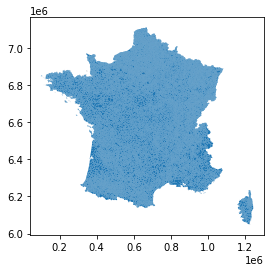

In [4]:
""" Plot France municipal geographical boundaries """
communes.plot()

### x.x.1 — Urban Areas

> Une aire urbaine ou "grande aire urbaine" est un ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle urbain (unité urbaine) de plus de 10 000 emplois, et par des communes rurales ou unités urbaines (couronne périurbaine) dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.

> Le zonage en aires urbaines 2010 distingue également :

> * les "moyennes aires", ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle (unité urbaine) de 5 000 à 10 000 emplois, et par des communes rurales ou unités urbaines dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.
> * les "petites aires", ensemble de communes, d'un seul tenant et sans enclave, constitué par un pôle (unité urbaine) de 1 500 à 5 000 emplois, et par des communes rurales ou unités urbaines dont au moins 40 % de la population résidente ayant un emploi travaille dans le pôle ou dans des communes attirées par celui-ci.

> Les aires urbaines, datées de 2010, ont été établies en référence à la population connue au recensement de 2008.

Source: INSEE. *Base des aires urbaines*. Online: https://www.insee.fr/fr/information/2115011. 

#### x.x.1.1 — Input *Tranches d'aires urbaines*

INSEE ranks *Tranches d'aires urbaines* into 11 levels: 

* 00: Commune hors aire urbaine
* 01: Commune appartenant à une aire urbaine de moins de 15 000 habitants
* 02: Commune appartenant à une aire urbaine de 15 000 à 19 999 habitants
* 03: Commune appartenant à une aire urbaine de 20 000 à 24 999 habitants
* 04: Commune appartenant à une aire urbaine de 25 000 à 34 999 habitants
* 05: Commune appartenant à une aire urbaine de 35 000 à 49 999 habitants
* 06: Commune appartenant à une aire urbaine de 50 000 à 99 999 habitants
* 07: Commune appartenant à une aire urbaine de 100 000 à 199 999 habitants
* 08: Commune appartenant à une aire urbaine de 200 000 à 499 999 habitants
* 09: Commune appartenant à une aire urbaine de 500 000 à 9 999 999 habitants
* 10: Commune appartenant à l'aire urbaine de Paris 

We first input the list of  from an INSEE spreedsheet. In the table, we find four variable:

* **AU2010**: INSEE code of the *aire urbaine* as defined in 2010;
* **LIBAU2010**: label of this *aire urbaine*;
* **TAU2017**: *Tranche d'aire urbaine* as defined in 2017; and 
* **NB_COM**: number of municipalities included in the *aire urbaine*.

In [6]:
""" List Urban Areas
    Dataset name: Base des aires urbaines
    Data provider: INSEE 
    Location: https://www.insee.fr/fr/information/2115011
"""
f = '../data/insee-data-AU2010-200101.xlsx'
urban_areas = pd.read_excel(f, sheet_name='AU2010', header=5)
urban_areas.head()

,AU2010,LIBAU2010,TAU2017,NB_COM
0,000,Communes isolées hors influence des pôles,0,7006
1,001,Paris,10,1751
2,002,Lyon,9,498
3,003,Marseille - Aix-en-Provence,9,90
4,004,Toulouse,9,452


From this table, we look how many *Tranches d'aires urbaines* exist, how many *aires urbaines* exist, and how many municipalities belong to an *Aire urbaine*.

In [23]:
""" Number of geographical units """
pd.DataFrame.from_dict({"Urban areas":urban_areas.shape[0],
"Tranches d'aire urbaine":len(urban_areas['TAU2017'].unique()),
"Municipalities":urban_areas['NB_COM'].sum()}, orient='index', columns=['Count'])

,Count
Urban areas,793
Tranches d'aire urbaine,11
Municipalities,34968


We also look at how many municipalities are situated in each urabn area rank. This gives us an idea of the importance of each rank in terms of area.

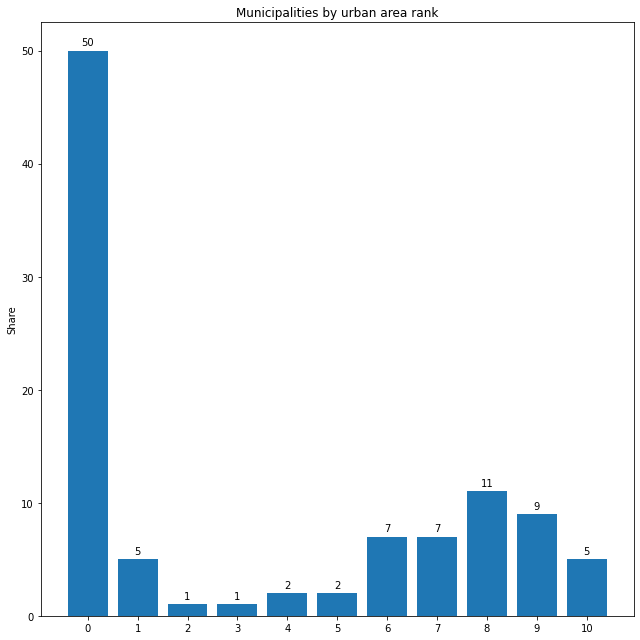

In [74]:
""" Share of municipalities by Tranche d'aire urbaine """
data = pd.DataFrame(urban_areas.groupby('TAU2017')['NB_COM'].sum() / urban_areas['NB_COM'].sum())

# Convert values to percentage integers
data = data.apply(lambda x: round(x, 2)*100)
data['NB_COM'] = data['NB_COM'].astype(int)

# Plot share of municipalities
labels = [str(x) for x in data.index]
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots(figsize=(9,9))
rects1 = ax.bar(x, data.values.ravel(), width, label='Share municipalities')

ax.set_ylabel('Share')
ax.set_title("Municipalities by urban area rank")
ax.set_xticks(x)
ax.set_xticklabels(labels)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)

fig.tight_layout()

plt.show()

From this table, we see that most municipalities are outside an urban area (49.67%). Contrary to what could be expected, the share of municipalities in each *Tranche d'aire urbaine* does not follow a *Zipf Law

#### x.x.1.2 — Input *Zonage en aires urbaines*

Second, we input a list of all municipalities and their corresponding classification. In this table, we find five additional variables:

* **CODGEO**: INSEE code of the municipality;
* **LIBGEO**: Name of the municipality;
* **CATAU2010**: INSEE code of the *zone en aire urbaine* as defined in 2010;
* **DEP**: INSEE code of the department in which the municipality is located;
* **REG**: INSEE code of the region in which the municipality is located.

In [7]:
""" List Urban Areas Communes
    Dataset name: Base des aires urbaines
    Data provider: INSEE 
    Location: https://www.insee.fr/fr/information/2115011
"""
f = '../data/insee-data-AU2010-200101.xlsx'
ua_communes = pd.read_excel(f, sheet_name='Composition_communale', header=5)
ua_communes.head()

,CODGEO,LIBGEO,AU2010,LIBAU2010,CATAEU2010,DEP,REG
0,01001,L'Abergement-Clémenciat,997,Multipolarisé des grands pôles,120,01,84
1,01002,L'Abergement-de-Varey,002,Lyon,112,01,84
2,01004,Ambérieu-en-Bugey,002,Lyon,112,01,84
3,01005,Ambérieux-en-Dombes,002,Lyon,112,01,84
4,01006,Ambléon,998,Autre multipolarisé,300,01,84


In this data, labels for the *Zonage en aire urbaine* (CATAEU2010) are:
* 111 : Commune appartenant à un grand pôle (10 000 emplois ou plus)
* 112 : Commune appartenant à la couronne d'un grand pôle
* 120 : Commune multipolarisée des grandes aires urbaines
* 211 : Commune appartenant à un moyen pôle (5 000 à moins de 10 000 emplois)
* 212 : Commune appartenant à la couronne d'un moyen pôle
* 221 : Commune appartenant à un petit pôle (de 1 500 à moins de 5 000 emplois)
* 222 : Commune appartenant à la couronne d'un petit pôle
* 300 : Autre commune multipolarisée
* 400 : Commune isolée hors influence des pôles

## 3 — Mapping

### 3.1 — Urban areas

### 3.1.1 — Urban area rank
Using the data we have input, we visualize the geographical distribution of the urban area rank unto a map.

In [75]:
communes.set_index('CODE').join(ua_communes.set_index('CODGEO'))

,gml_id,LIBELLE,geometry,LIBGEO,AU2010,LIBAU2010,CATAEU2010,DEP,REG
CODE,,,,,,,,,
01001,COMMUNE.01001,L'ABERGEMENT-CLEMENCIAT,"MULTIPOLYGON (((851129.600 6563369.200, 851107...",L'Abergement-Clémenciat,997,Multipolarisé des grands pôles,120.0,01,84.0
01002,COMMUNE.01002,L'ABERGEMENT-DE-VAREY,"MULTIPOLYGON (((888109.700 6545455.900, 888077...",L'Abergement-de-Varey,002,Lyon,112.0,01,84.0
01004,COMMUNE.01004,AMBERIEU-EN-BUGEY,"MULTIPOLYGON (((886593.000 6540886.000, 886567...",Ambérieu-en-Bugey,002,Lyon,112.0,01,84.0
01005,COMMUNE.01005,AMBERIEUX-EN-DOMBES,"MULTIPOLYGON (((850413.200 6544061.000, 850356...",Ambérieux-en-Dombes,002,Lyon,112.0,01,84.0
01006,COMMUNE.01006,AMBLEON,"MULTIPOLYGON (((899820.100 6520340.200, 900065...",Ambléon,998,Autre multipolarisé,300.0,01,84.0
...,...,...,...,...,...,...,...,...,...
95676,COMMUNE.95676,VILLERS-EN-ARTHIES,"MULTIPOLYGON (((608055.500 6889548.300, 608173...",Villers-en-Arthies,001,Paris,112.0,95,11.0
95678,COMMUNE.95678,VILLIERS-ADAM,"MULTIPOLYGON (((646949.800 6886548.200, 646910...",Villiers-Adam,001,Paris,111.0,95,11.0
95680,COMMUNE.95680,VILLIERS-LE-BEL,"MULTIPOLYGON (((656850.600 6880633.400, 656904...",Villiers-le-Bel,001,Paris,111.0,95,11.0


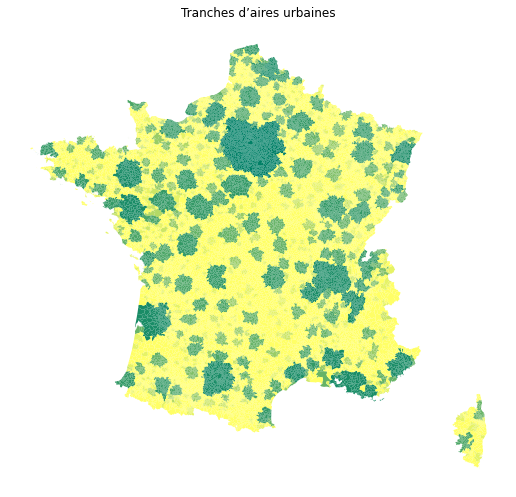

In [109]:
""" Map INSEE's Tranches d'aires urbaines """
fig, ax = plt.subplots(figsize=(9,9))
data = communes.set_index('CODE').join(ua_communes.set_index('CODGEO'))
# Create a new variable for TAU2017 by replacing AU2010 through dict
data['TAU2017'] = data['AU2010'].replace(urban_areas.set_index('AU2010')['TAU2017'].to_dict())

data.plot(ax=ax, column='TAU2017', cmap='summer_r')
plt.title('Tranches d’aires urbaines')
ax.axis('off')

plt.show()

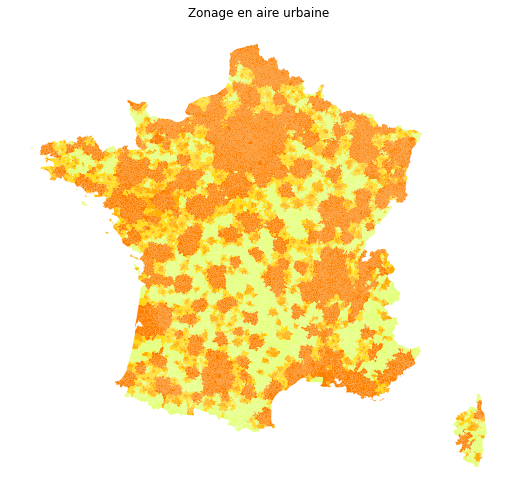

In [108]:
""" Map INSEE's 'Zonage en aires urbaines' """
fig, ax = plt.subplots(figsize=(9,9))
data = communes.set_index('CODE').join(ua_communes.set_index('CODGEO'))
data.plot(ax=ax, column='CATAEU2010', cmap='Wistia_r')
plt.title('Zonage en aire urbaine')
ax.axis('off')

plt.show()

The maps above show the *Tranches d'aires urbaines* and the *Zonage en aire urbaine*. The former is a categorical variable with 793 values, while the later is a ordinal variable with 9 values.